# One Plane 2D model
- The following notebook contains the solution for optimal control for the one plane problem in 2D
- The solver is in the package "Model_2D_Package"
- First is the solution from the bolza definition
- Then the solution from the min -w, where w<=h(t) for all t
- Last is a function for reconstructing a more detail trajectory when solving for low u values

In [8]:
%reset -f

import matplotlib.pyplot as plt
from casadi import *

import importlib
import Model_2D_Package.One_Plane_2D_solvers as model
importlib.reload(model)


<module 'Model_2D_Package.One_Plane_2D_solvers' from 'C:\\Users\\irmas\\Documents\\TUM\\CaseCourse\\CasADi\\Main\\Model_2D\\Model_2D_Package\\One_Plane_2D_solvers.py'>

## Bolza model

Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   1.7608681056129841e+04    1.4944762759075024e+12
Dual infeasibility......:   1.3002932064409833e-11    1.1035791622071942e-03
Constraint violation....:   1.8189894035458565e-12    1.8189894035458565e-12
Variable bound violation:   9.9999999392252903e-09    9.9999999392252903e-09
Complementari

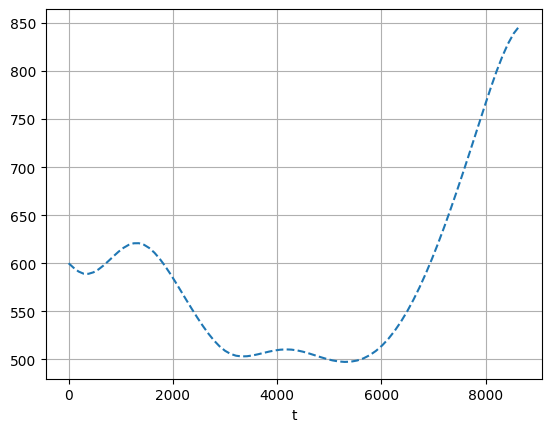

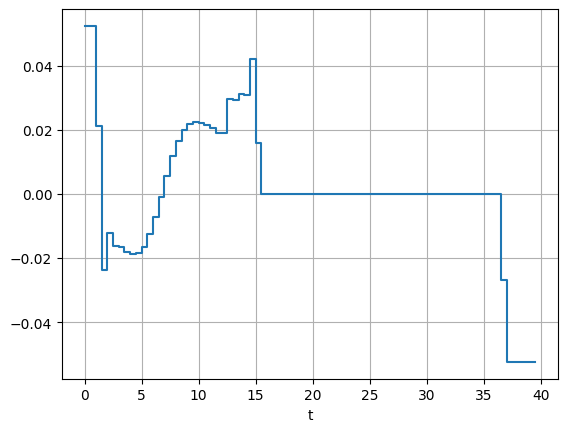

In [9]:
sol = model.solve_ocp_one_plane_bolza(k_value=1.0)

# plot
N = model.params.nu
tf = model.params.tf
tgrid = [tf/N*k for k in range(N+1)]

print("Optimal cost J* =", sol['w'])
print(min(sol['h']))

plt.figure(1)
plt.clf()
plt.plot(sol['x'], sol['h'], '--')
plt.xlabel('t')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(tgrid[:-1], sol['u'], where='post')
plt.xlabel('t')
plt.grid()
plt.show()  

## min -w Model

Total number of variables............................:      481
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:  -5.1310875598186976e+02   -5.1310875598186976e+02
Dual infeasibility......:   2.0776228804943398e-11    2.0776228804943398e-11
Constraint violation....:   1.5507737316511339e-09    1.5507737316511339e-09
Variable bound violation:   9.9845374190721259e-09    9.9845374190721259e-09
Complementari

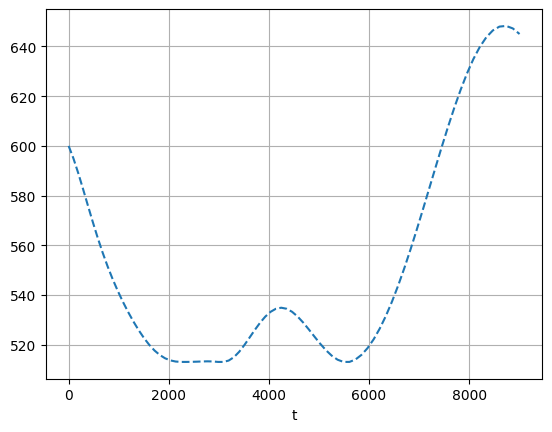

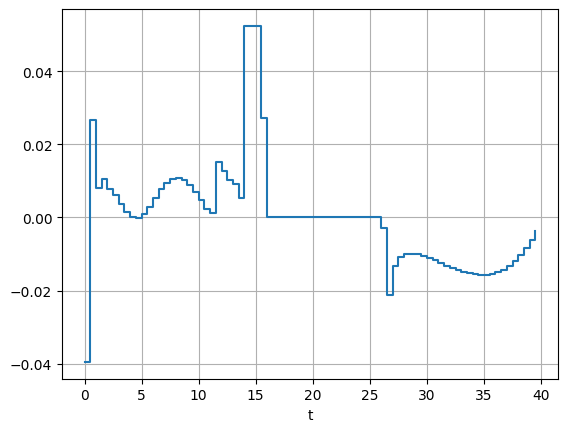

In [4]:

sol = model.solve_ocp_one_plane_min_h(k_value=1.0)

# plot
N = model.params.nu
tf = model.params.tf
tgrid = [tf/N*k for k in range(N+1)]

print("Optimal cost J* =", sol['w'])
print(min(sol['h']))

plt.figure(1)
plt.clf()
plt.plot(sol['x'], sol['h'], '--')
plt.xlabel('t')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(tgrid[:-1], sol['u'], where='post')
plt.xlabel('t')
plt.grid()
plt.show()  

## Reconstruction function

In [5]:
params = model.params

def reconstruction(u_opt, k_value, multipler):
    N = params.nu*multipler
    dt = params.tf/N
    
    # State, Time and Control
    x1 = MX.sym('x1')       # x
    x2 = MX.sym('x2')       # h
    x3 = MX.sym('x3')       # V
    x4 = MX.sym('x4')       # gamma
    x5 = MX.sym('x5')       # alpha
    t = MX.sym('t')         # time
    u = MX.sym('u')         # control
    x = vertcat(x1,x2,x3,x4,x5)   
    
    # Wind
    A1 = -50 + params.a * x1**3 + params.b * x1**4
    A2 = 0.025 * (x1 - 2300)
    A3 = 50 - params.a * (4600 - x1)**3 - params.b * (4600 - x1)**4
    A4 = 50 
    A = if_else(x1 <= 500, A1,
        if_else(x1 <= 4100, A2,
        if_else(x1 <= 4600, A3, A4)))
    A_piecewise = Function('A_piecewise', [x1], [A])
    
    B1 = params.d * x1**3 + params.e * x1**4
    B2 = -51 * exp(fmin(-params.c * (x1 - 2300)**4, 30))
    B3 = params.d * (4600 - x1)**3 + params.e * (4600 - x1)**4
    B4 = 0
    B = if_else(x1 <= 500, B1,
        if_else(x1 <= 4100, B2,
        if_else(x1 <= 4600, B3, B4)))
    B_piecewise = Function('B_piecewise', [x1], [B])
    
    wind_x_expr = k_value * A
    wind_x = Function('wind_x', [x1], [wind_x_expr])
    wind_h_expr = k_value * x2 * B / params.h_star
    wind_h = Function('wind_h', [x1, x2], [wind_h_expr])
    
    dWx_dx = Function("dWx_dx", [x1], [gradient(wind_x_expr, x1)])
    dWh_dx = Function("dWh_dx", [x1, x2], [gradient(wind_h_expr, x1)])
    dWh_dh = Function("dWh_dh", [x1, x2], [gradient(wind_h_expr, x2)])
    
    # Other functions
    C_L = if_else(x5 > params.alpha_star, params.C0 +params.C1 * x5, 
                       params.C0 + params.C1 * x5 + params.C2 * (x5 - params.alpha_star)**2)
    
    beta = if_else(t < params.sigma, 
                        params.beta0 + params.beta_dot0 * t, 1.0)
    
    T = beta * (params.A0 + params.A1 * x3 + params.A2 * x3**2)
    
    D = 0.5 * (params.B0 + params.B1 * x5 + params.B2 * x5**2) * params.rho * params.S * x3**2

    L = 0.5 * params.rho * params.S * C_L * x3**2
    
    # ode
    x1dot = x3 * cos(x4) + wind_x(x1)
    x2dot = x3 * sin(x4) + wind_h(x1,x2)
    
    wxdot = dWx_dx(x1) * x1dot
    whdot = dWh_dx(x1,x2) * x1dot + dWh_dh(x1,x2) * x2dot
    x3_safe = fmax(x3, 1e-3)
    
    x3dot = T / params.m * cos(x5 + params.delta) - D / params.m - params.g * sin(x4) - (wxdot * cos(x4) + whdot * sin(x4))
    x4dot = T / (params.m * x3) * sin(x5 + params.delta) + L / (params.m * x3) - params.g / x3_safe * cos(x4) + (1 / x3_safe) * (wxdot * sin(x4) - whdot * cos(x4))
    x5dot = u
    
    f = Function('f', [x, u, t], [vertcat(x1dot, x2dot, x3dot, x4dot, x5dot)])
    
    x2dotdot_expr = x3dot*sin(x4) + x3*x4dot*cos(x4) + whdot
    x2dotdot = Function('x2dotdot', [x, u, t], [x2dotdot_expr])
    
    # objective function
    Q = (params.hR-x2)**params.q
    qf = Function('qf', [x], [Q])
    
    # Integration
    def rk4_step(xk, uk, tk, dt, qk):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        qk1 = qf(xk)
        qk2 = qf(xk + dt/2 * k1)
        qk3 = qf(xk + dt/2 * k2)
        qk4 = qf(xk + dt * k3)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4), qk + dt/6 * (qk1 + 2*qk2 + 2*qk3 + qk4)
    
    # Prep
    U = []
    for k in range(params.nu):
        for i in range(multipler):
            U.append(u_opt[k])
            
    X = [] 
    J = 0  
    
    # initial condition
    Xk = [0, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
    X.extend(Xk)
    Tk = 0
    
    for k in range(N):
        Xk, J = rk4_step(Xk, U[k], Tk, dt, J)
        Tk += dt
        X.extend(Xk.full().flatten())
    
    T = [params.tf/N*k for k in range(N+1)]
    
    return X,J,U,T

Optimal cost J* = 1.73556e+12
512.9826268255766


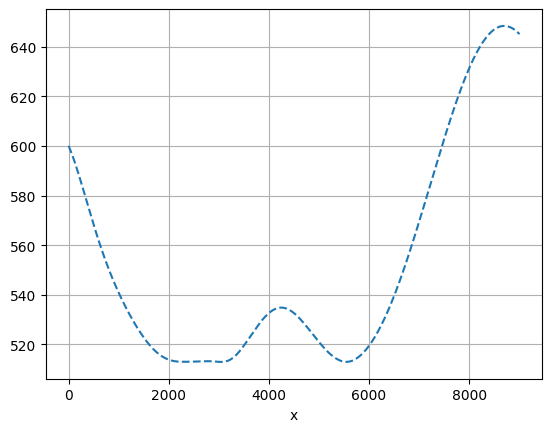

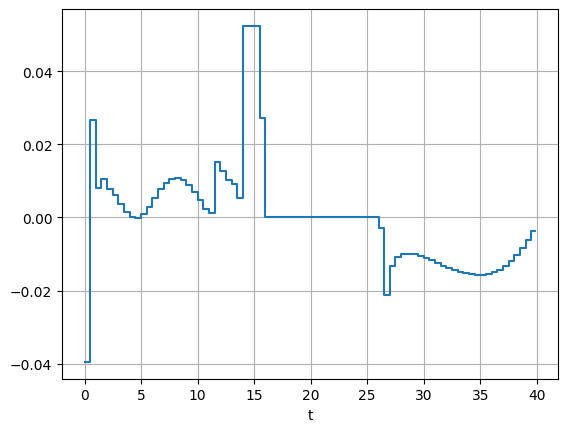

In [6]:

# Plot
X, J, U, T = reconstruction(sol['u'], k_value=1, multipler=4)


x1_opt = X[0::5]    # start at index 0, get every 6th:
x2_opt = X[1::5]   
x3_opt = X[2::5]  
x4_opt = X[3::5] 
x5_opt = X[4::5]


print("Optimal cost J* =", J)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('x')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(T[:-1], U, where='post')
plt.xlabel('t')
plt.grid()
plt.show()  

